## Einleitung
Im folgenden Notebook werden die csv-Daten für die KfZ-Zulassung und die Hagel-Daten für jeden Kanton 
kombiniert, um Visualisierungen über Orte mit höherem Risiko für die Versicherung zu erstellen.

* [Erforderliche Python-Bibliotheken](#python_libraries)

* [Einlesen der Eingabedatei](#read_input_file)
    
* [Zusammenführen von Hagel- und Autodaten](#merge_kfz_hail)

* [Visualisierung der kombinierten Ergebnisse](#visualization_results)


<a id="python_libraries"></a>
## Erforderliche Python-Bibliotheken

In [161]:
import os
from pathlib import Path
#import xarray as xr
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
# This is needed for the grid visualization later
from mpl_toolkits.axes_grid1 import ImageGrid

<a id="read_input_file"></a>
## Einlesen der Eingabedatei

In [163]:
# Files are saved in the "processed" folder 
processed_data_path = Path("./data/processed")

kfz_data = pd.read_csv(processed_data_path/'interim_kfz_data.csv', sep=";")
hail_data = pd.read_csv(processed_data_path/'haildata_per_month_canton.csv', sep=",")

In [164]:
# Selecting certain columns
columns_to_select = ['year', 'canton', 'haildays_per_point']

# Deep copy of selected columns
hail_data_copy = copy.deepcopy(hail_data[columns_to_select])

#changing names of columns so that we have similar names between hail and kfz data
# Rename columns using a dictionary
new_column_names = {
    'year': 'Jahr',
    'canton': 'Kanton',
    'haildays_per_point': 'number of hail days'
}

hail_data_copy = hail_data_copy.rename(columns=new_column_names)


In [165]:
hail_data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Jahr                 541 non-null    int64  
 1   Kanton               541 non-null    object 
 2   number of hail days  541 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.8+ KB


<a id="merge_kfz_hail"></a>
## Zusammenführen von Hagel- und Autodaten

In [168]:
# Merge haildays and kfz dataframes by multiindex
#Because the KfZ data is available only after 2005, the data from hail dataframe is filtered first

# Filter the data in the first dataframe based on Jahr >= 2005
hail_data_filtered = hail_data_copy[hail_data_copy['Jahr'] >= 2005]

# Perform the inner join on Kanton and Jahr columns
kfz_hail_df = pd.merge(hail_data_filtered, kfz_data, on=['Kanton', 'Jahr'], how='inner')

# Print the merged dataframe header
kfz_hail_df.head()


,Jahr,Kanton,number of hail days,Total_KFZ
0,2005,AG,0.669080,311370
1,2006,AG,1.283128,316298
2,2007,AG,0.573497,321731
3,2008,AG,0.632875,327074
4,2009,AG,1.837075,329151


Eine neue Spalte wird durch Multiplikation der Elemente der Spalte *number of hail days* und *Total-KFZ* erstellt. 

Die Einheit der neuen Spalte ist **HagelTag x Auto**. 

Die Idee dabei ist, dass das Risiko proportional zur Anzahl der Hageltage und der Anzahl der Autos ist. Wenn es beispielsweise 100 Autos in einem bestimmten Kanton und 10 Hageltage gibt, wird angenommen, dass das Risiko dem Fall entspricht, dass wir 1000 Autos und 1 Tag mit Hagel haben.

In [169]:
# A new column is created by multiply elements of column "number of hail days" and "Total-KFZ" 
# The Unite of the new column is "day-car". Idea here is that risk is proportional to number of haildays and number of cars
# as an example, if there were 100 cars in a specific canton and 10 days of hail, the risk is assumed to be equal 
# to the case where we had 1000 cars and 1 day with hail.

kfz_hail_df["hailday_kfz"] =kfz_hail_df.apply(lambda row: row['number of hail days'] * row['Total_KFZ'], axis=1)


In [170]:
# Column Jahr is in int64 format so we covert that column 
kfz_hail_df['Jahr'] = pd.to_datetime(kfz_hail_df['Jahr'], format='%Y').dt.strftime('%Y')

kfz_hail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 462
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Jahr                 463 non-null    object 
 1   Kanton               463 non-null    object 
 2   number of hail days  463 non-null    float64
 3   Total_KFZ            463 non-null    int64  
 4   hailday_kfz          463 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 21.7+ KB


In [179]:
# To make more sense of the data, the *hailday_kfz* is normalized per 100k autos.

kfz_hail_df['hailday_kfz_normalized'] = kfz_hail_df['hailday_kfz'] / 100000
kfz_hail_df = kfz_hail_df.sort_values('Jahr', ascending=False).reset_index(drop=True)

In [180]:
kfz_hail_df.head()

,index,Jahr,Kanton,number of hail days,Total_KFZ,hailday_kfz,hailday_kfz_normalized
0,462,2022,ZH,1.322773,754340,997820.932457,9.978209
1,228,2022,NE,1.162921,97015,112820.814607,1.128208
2,246,2022,NW,3.609023,27897,100680.902256,1.006809
3,192,2022,JU,2.556319,44564,113919.785714,1.139198
4,174,2022,GR,0.959957,116859,112179.639156,1.121796


<a id="visualization_results"></a>
## Visualisierung der kombinierten Ergebnisse

### Bar running chart

In [173]:
!pip install bar_chart_race

Defaulting to user installation because normal site-packages is not writeable


In [174]:
import bar_chart_race as bcr

In [181]:
# To create a race bar chart, data has to be in wide format. 
# A wide format contains values that do not repeat in the first column.)

# Convert to wide format
kfz_hail_wide = kfz_hail_df.pivot(index='Jahr', columns='Kanton', values='hailday_kfz_normalized')

In [182]:
kfz_hail_wide

Kanton,AG,AI,AR,BE,BL,BS,FR,GE,GL,GR,...,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
Jahr,,,,,,,,,,,,,,,,,,,,,
2005,2.083316,0.055260,0.050603,3.475188,1.871992,1.290696,1.040112,2.397995,0.104115,0.118010,...,0.401761,1.507782,0.319749,0.412158,1.256738,0.021542,2.831992,0.074848,0.464974,1.058576
2006,4.058509,0.120232,0.421172,7.960566,3.506961,0.579897,1.039009,0.028073,0.248783,0.310779,...,0.367299,2.447083,1.374025,0.648087,2.142790,0.084289,1.790435,0.216813,0.731876,2.701073
2007,1.845119,0.048533,0.052316,5.310062,1.585603,0.578895,1.451630,0.158036,0.074476,0.155549,...,0.053966,1.557855,0.630722,0.278462,1.441363,0.029137,1.976076,0.064419,0.102452,1.214342
2008,2.069969,0.146230,0.369739,4.559537,1.133888,1.100109,2.571872,0.082324,0.241891,0.237553,...,0.379919,0.774811,1.155242,0.874642,1.632932,0.081080,3.512725,0.170412,0.757902,6.052644
2009,6.046749,0.201922,0.547787,7.419071,2.788325,1.760857,2.287705,0.939535,0.146587,0.154258,...,0.444914,2.028734,0.526293,2.769735,1.994867,0.029947,3.274995,0.347771,0.967512,6.942553
2010,2.000660,0.080933,0.290681,4.122312,1.227273,1.112876,0.449976,NaN,0.208923,0.106197,...,0.029666,0.734331,1.014804,0.534425,0.647259,0.058373,1.253814,0.097947,1.231037,2.732739
2011,4.386123,0.089142,0.308257,4.463657,1.655484,0.665230,0.106403,NaN,0.045392,0.024236,...,0.749812,2.034632,0.802645,1.756414,0.830071,0.010786,0.285603,0.010488,1.058764,6.117413
2012,2.554771,0.033543,0.116366,2.568904,0.371375,0.212703,0.237552,0.267782,0.120221,0.093785,...,0.186929,0.232356,1.107578,0.695612,1.911611,0.043729,0.613454,0.120836,0.315827,8.933551
2013,0.137350,0.008193,0.053410,3.379604,0.057411,NaN,0.269064,2.072978,0.077175,0.063996,...,0.115476,0.376993,0.367039,0.250061,1.868546,0.011888,1.642445,0.198071,0.437355,4.699885


<div class="alert alert-block alert-warning">
Wichtiger Hinweis: <b>ffmpeg</b> sollte auf dem Computer installiert sein, um das folgende Race-Bar-Diagramm auszuführen.
</div>

Installation von **ffmpeg** :

Für Windows:

1. Visit the official ffmpeg website: https://www.ffmpeg.org/download.html.
2. Scroll down to the "Windows Builds" section and click on the link corresponding to "Download FFmpeg".
3. Choose the appropriate version based on your system architecture (32-bit or 64-bit).
4. Extract the downloaded zip file to a directory of your choice.
5. Add the path to the ffmpeg executable (e.g., ffmpeg/bin) to your system's PATH environment variable.

Für macOS:

1. Open a terminal.
2. Install Homebrew if you haven't already. Visit the Homebrew website (https://brew.sh/) and follow the installation instructions.
3. Once Homebrew is installed, run the following command in the terminal:

- *brew install ffmpeg*

Für Linux (Ubuntu):

1. Open a terminal.
2. Run the following command to install ffmpeg:
    
- *sudo apt-get update*
- *sudo apt-get install ffmpeg*


In [183]:
import warnings
warnings.filterwarnings('ignore')

# for settings, see here: https://www.dexplo.org/bar_chart_race/api/

bcr.bar_chart_race(
    df = kfz_hail_wide, 
    title = "Hageltagen x Anzahl Autos per Kanton (x100k)", 
    n_bars=10, 
    orientation='h', 
    fixed_order= False,
    fixed_max = True,
    cmap = 'prism',
    steps_per_period=10, 
    period_length=1000, 
    label_bars = False)
     

### Raster der einzelnen Balkendiagramme pro Jahr

Die einzelnen Balkendiagramme für jedes Jahr dienen dem Vergleich des Hagelrisikos für Autos in den verschiedenen Kantonen.

In [154]:
# Below setting is to avoid a scroll down for the figures (full screen figure)

In [135]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

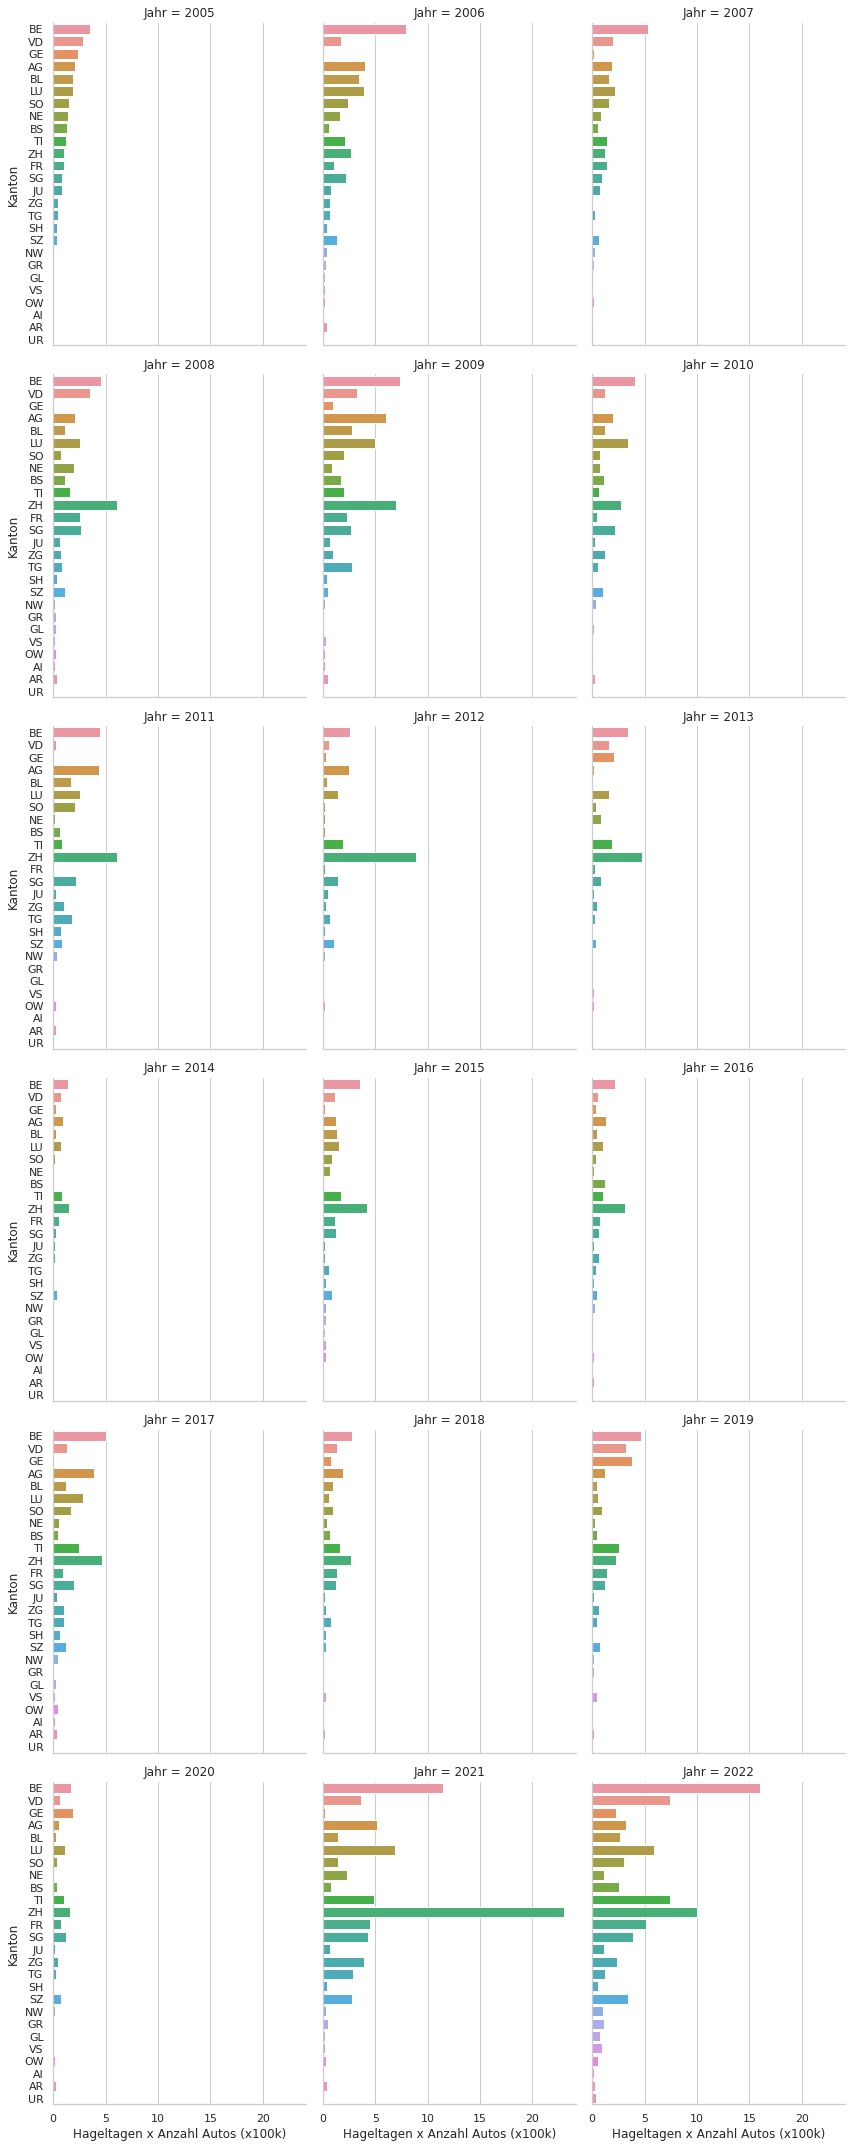

In [189]:
sns.catplot(
    data=kfz_hail_df.groupby('Jahr').apply(lambda x: x.sort_values('hailday_kfz_normalized',ascending=False)).reset_index(drop=True), 
    x="hailday_kfz_normalized", 
    y="Kanton", 
    col="Jahr",
    kind="bar", 
    height=5, 
    aspect=.8, 
    col_wrap=3,
    ).set_xlabels('Hageltagen x Anzahl Autos (x100k)')

plt.show()


### Balkendiagramm für den Durchschnitt über den gesamten Zeitraum

Im Folgenden wird der Durchschnitt von hailday_kfz_normalisiert über den gesamten Zeitraum berechnet.

In [192]:
df_average = kfz_hail_df.groupby('Kanton', as_index=False)['hailday_kfz_normalized'].mean().sort_values('hailday_kfz_normalized', ascending=False)

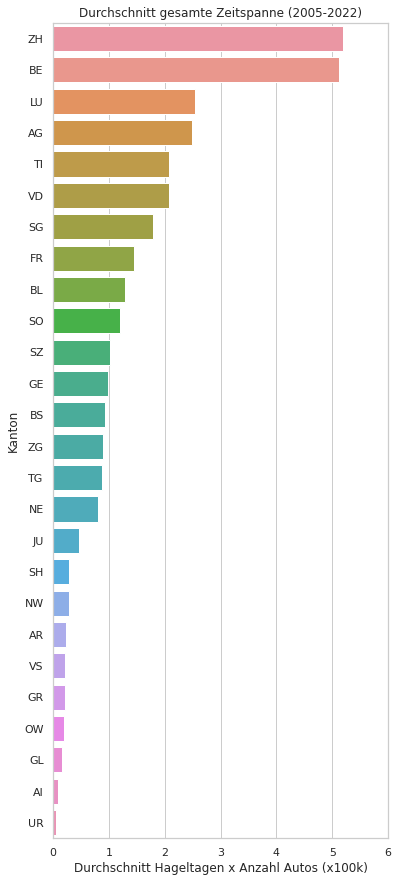

In [196]:
# Horizontal bar chart

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
df_average = kfz_hail_df.groupby('Kanton', as_index=False)['hailday_kfz_normalized'].mean().sort_values('hailday_kfz_normalized', ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="hailday_kfz_normalized", y="Kanton", data=df_average)

# Add a legend and informative axis label
ax.set(xlim=(0, 6), ylabel="Kanton",
       xlabel='Durchschnitt Hageltagen x Anzahl Autos (x100k)',
      title='Durchschnitt gesamte Zeitspanne (2005-2022)')

plt.show()

Basierend auf den jährlichen Hageltagen und der Anzahl der immatrikulierten Autos über den gesamten Zeitraum (2005-2022) sind die Kantone Zürich, Bern und Luzern die Kantone mit dem höchsten Risiko für die Autoversicherer.